# Data Merging and Preparation for Multi-Horizon LSTM
- Merge all datasets: crops, discharge, precipitation, hypoxia
- Create sequences for different forecast horizons

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [5]:
DATA_DIR = Path('data/processed')
OUTPUT_DIR = Path('data/modeling')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Years with complete data (excluding 2020, 2022 due to missing hypoxia)
USABLE_YEARS = [y for y in range(2001, 2025) if y not in [2020, 2022]]

# Forecast scenarios - (start_month, end_month) for each
FORECAST_SCENARIOS = {
    'early_warning': {
        'months': (1, 3),  # Jan-Mar
        'lead_time': '4-month',
        'description': 'Early warning forecast (March data available)'
    },
    'mid_season': {
        'months': (1, 5),  # Jan-May
        'lead_time': '2-month',
        'description': 'Mid-season forecast (May data available)'
    },
    'near_term': {
        'months': (1, 6),  # Jan-Jun
        'lead_time': '1-month',
        'description': 'Near-term forecast (June data available)'
    }
}

In [6]:
# Load hypoxia data (TARGET)
hypoxia_file = 'data/processed/hypoxia_aggregated_wide.csv'
hypoxia_df = pd.read_csv(hypoxia_file)

# Load crop data
crop_file = DATA_DIR / 'crop_acreage_state_level.csv'
crop_df = pd.read_csv(crop_file)

# Load discharge data
discharge_file = DATA_DIR / 'river_discharge_monthly.csv'
discharge_df = pd.read_csv(discharge_file)

# Load precipitation data
precip_file = DATA_DIR / 'precipitation_regional_monthly.csv'
precip_df = pd.read_csv(precip_file)

# Load wind data
wind_file = DATA_DIR / 'buoy_42040_wind_monthly.csv'
wind_df = pd.read_csv(wind_file)

In [7]:
# Sort by year to ensure proper lagging
hypoxia_df = hypoxia_df.sort_values('year').reset_index(drop=True)

# Create lag features for each zone
hypoxia_df['zone1_hypoxic_lag1'] = hypoxia_df['Zone1_percent_hypoxic'].shift(1)
hypoxia_df['zone2_hypoxic_lag1'] = hypoxia_df['Zone2_percent_hypoxic'].shift(1)

# Also add 2-year lag
hypoxia_df['zone1_hypoxic_lag2'] = hypoxia_df['Zone1_percent_hypoxic'].shift(2)
hypoxia_df['zone2_hypoxic_lag2'] = hypoxia_df['Zone2_percent_hypoxic'].shift(2)


In [8]:
# Filter to usable years
hypoxia_df = hypoxia_df[hypoxia_df['year'].isin(USABLE_YEARS)].copy()

In [9]:
# Convert discharge from wide to long format (year-month rows)
discharge_cols = [c for c in discharge_df.columns if c.startswith('discharge_') and c.endswith('_cfs')]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

discharge_long = []
for _, row in discharge_df.iterrows():
    year = row['year']
    for month_idx, month_name in enumerate(month_names, 1):
        col_name = f'discharge_{month_name}_cfs'
        if col_name in discharge_df.columns:
            discharge_long.append({
                'year': year,
                'month': month_idx,
                'discharge_cfs': row[col_name]
            })

discharge_monthly = pd.DataFrame(discharge_long)


monthly_features = discharge_monthly.merge(
    precip_df,
    on=['year', 'month'],
    how='outer'
).merge(
    wind_df[['year', 'month', 'wind_speed_mean_ms', 'wind_direction_mean_deg',
             'pct_strong_winds', 'water_temp_mean_C']],
    on=['year', 'month'],
    how='left'
)

# Add crop data (crops are annual, so repeat for each month)
crop_features = [c for c in crop_df.columns if c.endswith(('_corn', '_soy'))]
crop_annual = crop_df[['year'] + crop_features].copy()

monthly_features = monthly_features.merge(
    crop_annual,
    on='year',
    how='left'
)

# Filter to usable years and only Jan-Jun (we don't need July-Dec)
monthly_features = monthly_features[
    (monthly_features['year'].isin(USABLE_YEARS)) &
    (monthly_features['month'] <= 6)
].copy()

In [10]:
# Get all feature columns (exclude year and month)
feature_cols = [c for c in monthly_features.columns if c not in ['year', 'month']]

# Categorize features
discharge_features = ['discharge_cfs']
precip_features = [c for c in feature_cols if 'precip' in c]
wind_features = [c for c in feature_cols if 'wind' in c or 'water_temp' in c]
crop_features_list = [c for c in feature_cols if c.endswith(('_corn', '_soy'))]

total_features = len(feature_cols)

Note - Claude Code helped me create the next 2 function to add the lagged data

In [11]:
def create_sequences(monthly_data, hypoxia_data, scenario_name, start_month, end_month):
    """
    Create input sequences for a specific forecast scenario
    
    Parameters:
    - monthly_data: DataFrame with monthly features
    - hypoxia_data: DataFrame with annual hypoxia targets (now includes lag features)
    - scenario_name: Name of scenario (e.g., 'early_warning')
    - start_month: First month of sequence (1=Jan)
    - end_month: Last month of sequence (3=Mar, 5=May, 6=Jun)
    
    Returns:
    - sequences: List of dictionaries with year, X, y
    """
    
    sequences = []
    feature_cols_local = [c for c in monthly_data.columns if c not in ['year', 'month']]
    
    for year in USABLE_YEARS:
        # Get monthly data for this year (start_month through end_month)
        year_data = monthly_data[
            (monthly_data['year'] == year) & 
            (monthly_data['month'] >= start_month) &
            (monthly_data['month'] <= end_month)
        ].copy()
        
        # Get hypoxia target for this year
        hypoxia_row = hypoxia_data[hypoxia_data['year'] == year]
        
        # Check if we have complete data
        expected_months = end_month - start_month + 1
        if len(year_data) == expected_months and len(hypoxia_row) == 1:
            # Sort by month to ensure correct order
            year_data = year_data.sort_values('month')
            
            # Extract features (X) from monthly data
            X = year_data[feature_cols_local].values  # Shape: (n_months, n_features)
            
            # Get hypoxia targets (3 zones)
            y = hypoxia_row[[
                'Zone1_percent_hypoxic',
                'Zone2_percent_hypoxic', 
                'Zone3_percent_hypoxic'
            ]].values[0]  # Shape: (3,)
            
            # Add lagged hypoxia features (previous year's hypoxia)
            lag_features = hypoxia_row[[
                'zone1_hypoxic_lag1', 
                'zone2_hypoxic_lag1',
                'zone1_hypoxic_lag2',
                'zone2_hypoxic_lag2'
            ]].values[0]  # Shape: (4,)
            
            # Skip if lag features are NaN (first 1-2 years won't have lags)
            if np.isnan(lag_features).any():
                continue
            
            # Append lag features to each timestep
            # Lag features are annual, so repeat them for each month
            # Shape: (n_months, original_features) → (n_months, original_features + 4)
            lag_repeated = np.tile(lag_features, (X.shape[0], 1))
            X = np.hstack([X, lag_repeated])
            
            sequences.append({
                'year': year,
                'scenario': scenario_name,
                'X': X,
                'y': y,
                'n_timesteps': X.shape[0],
                'n_features': X.shape[1]
            })
    
    return sequences

# Create sequences for each forecast scenario
all_sequences = []

for scenario_name, scenario_info in FORECAST_SCENARIOS.items():
    start_month, end_month = scenario_info['months']
    lead_time = scenario_info['lead_time']
    description = scenario_info['description']
    
    sequences = create_sequences(
        monthly_features, 
        hypoxia_df, 
        scenario_name, 
        start_month, 
        end_month
    )
    all_sequences.extend(sequences)
    


In [ ]:
def pad_sequences_to_max_length(sequences, max_length=6):
    """
    Pad sequences to maximum length (6 months for near_term scenario)
    Different scenarios have different lengths (3, 5, 6 months)
    Padding at the beginning with zeros
    """
    
    X_list = []
    y_list = []
    years_list = []
    scenarios_list = []
    
    for seq in sequences:
        X = seq['X']
        y = seq['y']
        n_timesteps = X.shape[0]
        n_features = X.shape[1]
        
        # Pad with zeros at the beginning if needed
        if n_timesteps < max_length:
            padding = np.zeros((max_length - n_timesteps, n_features))
            X_padded = np.vstack([padding, X])
        else:
            X_padded = X
        
        X_list.append(X_padded)
        y_list.append(y)
        years_list.append(seq['year'])
        scenarios_list.append(seq['scenario'])
    
    return np.array(X_list), np.array(y_list), years_list, scenarios_list

X_train, y_train, train_years, train_scenarios = pad_sequences_to_max_length(train_sequences)
X_val, y_val, val_years, val_scenarios = pad_sequences_to_max_length(val_sequences)
X_test, y_test, test_years, test_scenarios = pad_sequences_to_max_length(test_sequences)



In [12]:
# Define year splits
TRAIN_YEARS = [y for y in range(2001, 2018)]  # 2001-2017: 17 years
VAL_YEARS = [2018, 2019, 2021]                 # 3 years  
TEST_YEARS = [2023, 2024]                      # 2 years

# Split sequences by year
train_sequences = [s for s in all_sequences if s['year'] in TRAIN_YEARS]
val_sequences = [s for s in all_sequences if s['year'] in VAL_YEARS]
test_sequences = [s for s in all_sequences if s['year'] in TEST_YEARS]

In [14]:
# Reshape to 2D for scaler: (samples * timesteps, features)
n_samples_train, n_timesteps, n_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, n_features)

scaler = StandardScaler()
scaler.fit(X_train_reshaped)

# Transform all sets
X_train_scaled = scaler.transform(X_train_reshaped).reshape(n_samples_train, n_timesteps, n_features)
X_val_scaled = scaler.transform(X_val.reshape(-1, n_features)).reshape(X_val.shape[0], n_timesteps, n_features)
X_test_scaled = scaler.transform(X_test.reshape(-1, n_features)).reshape(X_test.shape[0], n_timesteps, n_features)


# Save as numpy arrays
np.save(OUTPUT_DIR / 'X_train.npy', X_train_scaled)
np.save(OUTPUT_DIR / 'y_train.npy', y_train)
np.save(OUTPUT_DIR / 'X_val.npy', X_val_scaled)
np.save(OUTPUT_DIR / 'y_val.npy', y_val)
np.save(OUTPUT_DIR / 'X_test.npy', X_test_scaled)
np.save(OUTPUT_DIR / 'y_test.npy', y_test)

# Save metadata
metadata = {
    'feature_names': feature_cols,
    'target_names': ['Zone1_percent_hypoxic', 'Zone2_percent_hypoxic', 'Zone3_percent_hypoxic'],
    'zone_descriptions': ['Louisiana zone', 'Texas zone', 'Mexico zone'],
    'train_years': train_years,
    'val_years': val_years,
    'test_years': test_years,
    'train_scenarios': train_scenarios,
    'val_scenarios': val_scenarios,
    'test_scenarios': test_scenarios,
    'n_features': n_features,
    'n_timesteps': n_timesteps,
    'n_targets': 3,
    'usable_years': USABLE_YEARS,
    'forecast_scenarios': FORECAST_SCENARIOS
}

import pickle
with open(OUTPUT_DIR / 'metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

with open(OUTPUT_DIR / 'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


IndexError: list index out of range

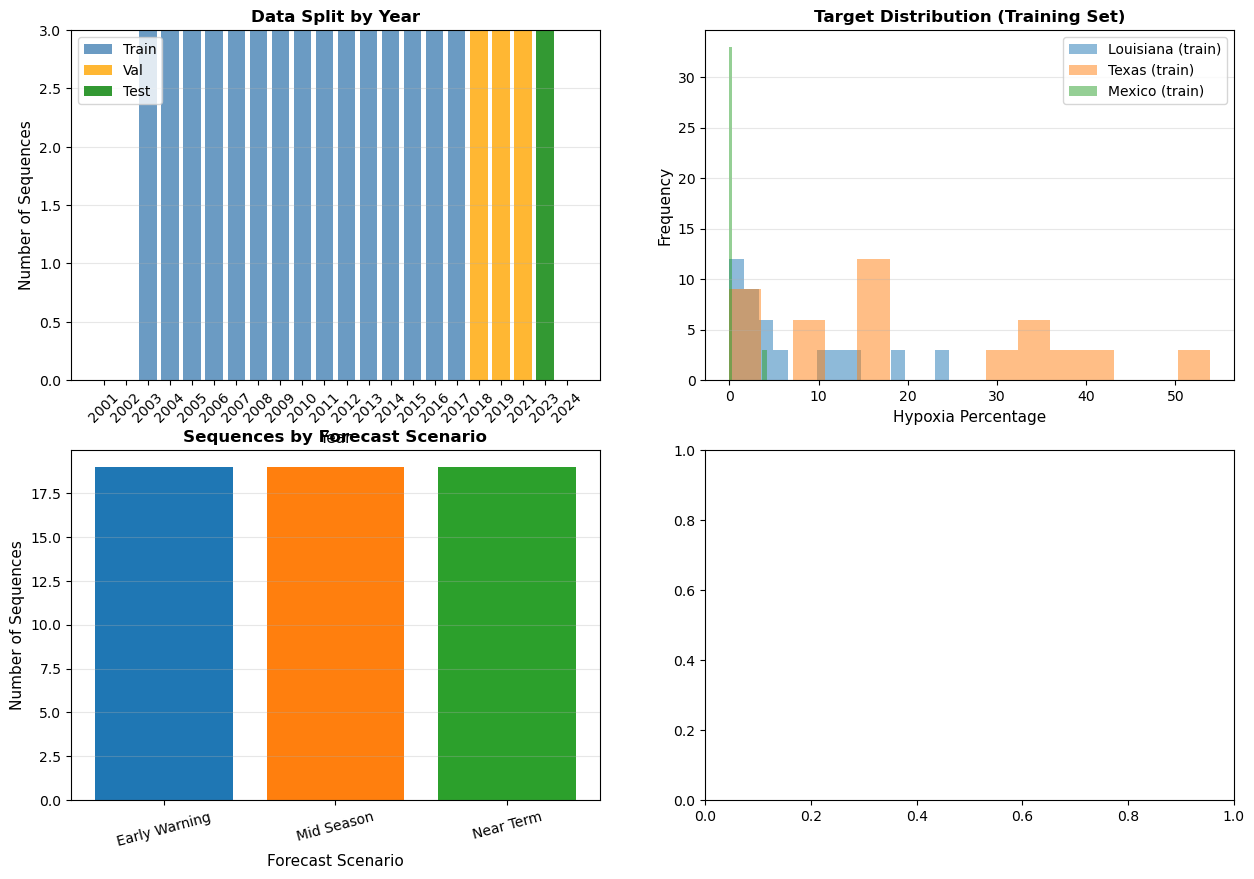

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Sample distribution by year and split
ax1 = axes[0, 0]
year_labels = []
train_counts = []
val_counts = []
test_counts = []

for year in USABLE_YEARS:
    year_labels.append(year)
    train_counts.append(train_years.count(year))
    val_counts.append(val_years.count(year))
    test_counts.append(test_years.count(year))

x = np.arange(len(year_labels))
width = 0.8
ax1.bar(x, train_counts, width, label='Train', alpha=0.8, color='steelblue')
ax1.bar(x, val_counts, width, bottom=train_counts, label='Val', alpha=0.8, color='orange')
ax1.bar(x, test_counts, width, bottom=np.array(train_counts)+np.array(val_counts), 
        label='Test', alpha=0.8, color='green')
ax1.set_xlabel('Year', fontsize=11)
ax1.set_ylabel('Number of Sequences', fontsize=11)
ax1.set_title('Data Split by Year', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(year_labels, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Target distribution (hypoxia percentages)
ax2 = axes[0, 1]
zone_names = ['Louisiana', 'Texas', 'Mexico']
for i, zone in enumerate(zone_names):
    ax2.hist(y_train[:, i], bins=15, alpha=0.5, label=f'{zone} (train)')
ax2.set_xlabel('Hypoxia Percentage', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Target Distribution (Training Set)', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Samples by forecast scenario
ax3 = axes[1, 0]
scenario_counts = {}
for scenario_name in FORECAST_SCENARIOS.keys():
    scenario_counts[scenario_name.replace('_', ' ').title()] = len([s for s in all_sequences if s['scenario'] == scenario_name])

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
ax3.bar(scenario_counts.keys(), scenario_counts.values(), color=colors)
ax3.set_xlabel('Forecast Scenario', fontsize=11)
ax3.set_ylabel('Number of Sequences', fontsize=11)
ax3.set_title('Sequences by Forecast Scenario', fontweight='bold')
ax3.set_xticklabels(scenario_counts.keys(), rotation=15)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Feature importance preview (mean absolute values in training set)
ax4 = axes[1, 1]
# Calculate mean absolute feature values across all timesteps (excluding padding zeros)
feature_means = np.abs(X_train_scaled[X_train_scaled != 0]).reshape(-1, n_features).mean(axis=0)
# Get top 15 features
top_15_idx = np.argsort(feature_means)[-15:]
top_15_names = [feature_cols[i][:25] for i in top_15_idx]  # Truncate names
top_15_values = feature_means[top_15_idx]

ax4.barh(range(len(top_15_names)), top_15_values, color='steelblue')
ax4.set_yticks(range(len(top_15_names)))
ax4.set_yticklabels(top_15_names, fontsize=8)
ax4.set_xlabel('Mean Absolute Scaled Value', fontsize=11)
ax4.set_title('Top 15 Features by Magnitude', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'data_summary.png', dpi=150, bbox_inches='tight')